# Imports

In [14]:
# code libraries
import numpy as np
import matplotlib.pyplot as plt
from vector_class import TripleVector
import random
from scipy.optimize import curve_fit

# code from simple single source
# from simple_singlePoint_source import visualize


In [15]:
# The goal is to improve the code so that the drone flies over the grid in a way that it firs locates the "hotspot" tile and then gathers the 
# information around it source. It dose this by flying around it in circles


# Parameters

In [16]:
A_min = 1e3 # Bq
A_max = 2e3 # Bq
A_b = 5e-5 # Bq
h = 10 # m
dt = 100 # the pause on each point od the grid in s
x_max = 4; sigma_x = 0.1 # m
y_max = 4; sigma_y = 0.1 # m
grid = 10
n_bins = 10
K = 0.1 # is somewhere in the interval [0, 1]
F = 0.140 # factor for inhilation of Pu-239 in mSV/Bq

""
n_points = 100
max_phi = 12*np.pi

radiation = {"A_min": A_min, "A_max": A_max, "A_b": A_b, "dt": dt, "dose_factor": F}
detector = {"h": h, "x_max": x_max, "y_max": y_max, "grid": grid, "detector_constant": K, "n_points": n_points, "max_phi": max_phi} # the detector constant tells us the quality of the 
                                                                                          # detector

## Subsidary code

In [17]:
def activity(source, x, y, h, ru=0, rv=0):
    u, v, A0 = source[0], source[1], source[2] # u, v are the coordinates of the source and A0 is its activity
    return (A0*(ru**2 + rv**2 + h**2)) / ((x - (u - ru))**2 + (y - (v - rv))**2 + h**2)

def point_source(x_max, y_max, A_min, A_max, x_min=0, y_min=0):
    if (x_min == 0) and (y_min == 0):    
        return [random.uniform(-x_max, x_max), random.uniform(-y_max, y_max), random.uniform(A_min, A_max)]
    else:
        return [random.uniform(x_min, x_max), random.uniform(y_min, y_max), random.uniform(A_min, A_max)]

# def simulated_event(source, x, y, h, grid_x_noise, grid_y_noise, noise=[], n="None", m="None"):
#     A = activity(source, x, y, h)
#     A_det = A * (1 - K)
#     N = np.random.poisson(A_det * dt)
#     N_b = np.random.poisson(A_b * dt)# background radiation

#     # Add noise to the location data because of the GPS uncertianty

#     if len(noise) != 0:
#         if (n != "None" and m != "None"):
#             sigma_x = noise[0]; sigma_y = noise[1]
#             grid_x_noise[n, m] = x + np.random.normal(0, sigma_x)
#             grid_y_noise[n, m] = y + np.random.normal(0, sigma_y)
#         else:
#             sigma_x = noise[0]; sigma_y = noise[1]
#             x += np.random.normal(0, sigma_x)
#             y += np.random.normal(0, sigma_y)

#     return {"number": N, "N_b": N_b, "grid_x_noise": grid_x_noise, "grid_y_noise": grid_y_noise, "x": x, "y": y}Sž

def dose_speed_xy(source, x, y, radiation, detector):
    A_b, dt = radiation["A_b"], radiation["dt"]
    h, K = detector["h"], detector["detector_constant"]
    
    A = activity(source, x, y, h)
    A_det = A * (1 - K)
    N = np.random.poisson(A_det * dt)
    N_b = np.random.poisson(A_b * dt)# background radiation

    HD = F * (N + N_b)


    dHD = F * np.sqrt(N + N_b)
    return [HD, dHD]



## Flyover

### Modified code that wil be used to spiral around a point

In [18]:
test_source = point_source(x_max, y_max, A_min, A_max)
# print(test_source)


In [19]:
NORTH, S, W, E = (0, -1), (0, 1), (-1, 0), (1, 0) # directions
anticlockwise = {NORTH: W, E: NORTH, S: E, W: S} # old -> new direction
clockwise = {NORTH: E, E: S, S: W, W: NORTH}

option1 = {"rotation": clockwise, "special": ''}
option2 = {"rotation": clockwise, "special": 'up'}
option3 = {"rotation": clockwise, "special": 'left+up'}
option4 = {"rotation": anticlockwise, "special": 'up'}
option5 = {"rotation": anticlockwise, "special": ''}

def measure(x, y, source, doses, coordinates, radiation, detector):
    X = grid_x[y, x]; Y = grid_y[y, x]; dose = dose_speed(source, X, Y, radiation, detector)[0]
    doses.append(dose)
    coordinates.append({"i": x, "j": y})
    return {"dos": doses, "coo": coordinates}

N_grid = grid
dx, dy = (2*x_max)/N_grid, (2*y_max)/N_grid
xs = np.linspace(-x_max + dx/2, x_max - dx/2, int(N_grid))
ys = np.flip(np.linspace(-y_max + dy/2, y_max - dy/2, int(N_grid)))
grid_x, grid_y = np.meshgrid(xs, ys)
grid_x_noise, grid_y_noise = np.zeros((N_grid, N_grid)), np.zeros((N_grid, N_grid))
data = {"h": h, "A_b": A_b, "K": K, "F": F, "dt": dt, "grid_x_noise": grid_x_noise, "grid_y_noise": grid_y_noise, "noise": []}

def spiral(tehnical, option, source, radiation, detector, count_max=9):
    doses = []; coordinates = []
    width = tehnical["width"]; height = tehnical["height"]; start_x = tehnical["start_x"]; start_y = tehnical["start_y"]
    turn_type = option["rotation"]; special = option["special"]
    if width < 1 or height < 1:
        raise ValueError
    x, y = start_x, start_y # start near the center
    dx, dy = NORTH # initial direction
    matrix = [[None] * width for _ in range(height)]
    count = 0
    while True:
        count += 1
        
        measuring = measure(x, y, source, doses, coordinates, radiation, detector)
        doses = measuring["dos"]; coordinates = measuring["coo"]
        matrix[y][x] = count
    
        if (special == "up" and count == 1):
            count += 1
            y -= 1

            measuring = measure(x, y, source, doses, coordinates, radiation, detector)
            doses = measuring["dos"]; coordinates = measuring["coo"]
            matrix[y][x] = count

        elif (special == "left+up" and count == 1):
            count += 1
            x -=1

            measuring = measure(x, y, source, doses, coordinates, radiation, detector)
            doses = measuring["dos"]; coordinates = measuring["coo"]
            matrix[y][x] = count

            count += 1
            y -= 1

            measuring = measure(x, y, source, doses, coordinates, radiation, detector)
            doses = measuring["dos"]; coordinates = measuring["coo"]
            matrix[y][x] = count

        if count_max <= count:
            return [doses[1:], coordinates[1:]]

        # try to turn right
        new_dx, new_dy = turn_type[dx,dy]
        new_x, new_y = x + new_dx, y + new_dy
        if not (0 <= new_x < width and 0 <= new_y < height):
                return [doses[1:], coordinates[1:]] # nowhere to go
        else:
            if (0 <= new_x < width and 0 <= new_y < height and matrix[new_y][new_x] is None): # can turn right
                x, y = new_x, new_y
                dx, dy = new_dx, new_dy
            else: # try to move straight
                x, y = x + dx, y + dy
                if not (0 <= x < width and 0 <= y < height):
                    return [doses[1:], coordinates[1:]] # nowhere to go



tehnical = {"width": grid, "height": grid, "start_x": 0, "start_y": 0}



### Flyover actually

In [20]:
def dose_speed(source, i, j, radiation, detector, grid_x, grid_y):
    A_b, dt = radiation["A_b"], radiation["dt"]
    h, K = detector["h"], detector["detector_constant"]

    x = grid_x[i, j]; y = grid_y[i, j]

    A = activity(source, x, y, h)
    A_det = A * (1 - K)
    N = np.random.poisson(A_det * dt)
    N_b = np.random.poisson(A_b * dt)# background radiation

    HD = F * (N + N_b)

    dHD = F * np.sqrt(N + N_b)
    return [HD, dHD]

def make_list(source, i, j, radiation, detector, grid_x, grid_y):
    N_grid = detector['grid']
    HDs = []; direction = []
    if j != (N_grid - 1): # go right
        HDs0 = dose_speed(source, i, j + 1, radiation, detector, grid_x, grid_y)
        HDs.append(HDs0[0])
        direction.append(0)
    if (i != (N_grid - 1)) and (j != (N_grid - 1)): # go diagonally
        HDs1 = dose_speed(source, i + 1, j + 1, radiation, detector, grid_x, grid_y)
        HDs.append(HDs1[0])
        direction.append(1)
    if i != (N_grid - 1): # go left
        HDs2 = dose_speed(source, i + 1, j, radiation, detector, grid_x, grid_y)
        HDs.append(HDs2[0])
        direction.append(2)
    max_HD = max(HDs)
    max_id = HDs.index(max_HD)
    d = direction[max_id]
    return [d, max_HD]

def r_ArhSpir(phi, k=1):
    return k * phi



def improv_flyOver(radiation, detector, source = []):
    A_min, A_max, A_b, dt = radiation['A_min'], radiation['A_max'], radiation['A_b'], radiation['dt']
    h, x_max, y_max, N_grid, K = detector['h'], detector['x_max'], detector['y_max'], detector['grid'], detector['detector_constant']
    n_points, max_phi = detector['n_points'], detector['max_phi']
    dx, dy = (2*x_max)/N_grid, (2*y_max)/N_grid
    
    # grid_x_noise, grid_y_noise = np.zeros((N_grid, N_grid)), np.zeros((N_grid, N_grid))
    xs = np.linspace(-x_max + dx/2, x_max - dx/2, int(N_grid))
    ys = np.flip(np.linspace(-y_max + dy/2, y_max - dy/2, int(N_grid)))
    grid_x, grid_y = np.meshgrid(xs, ys)
    # grid_x_noise, grid_y_noise = np.zeros((N_grid, N_grid)), np.zeros((N_grid, N_grid))
    map = np.zeros((N_grid, N_grid))
    
    if len(source) == 0:
        source = point_source(x_max, y_max, A_min, A_max)

    i, j = 0, 0
    HD = dose_speed(source, i, j, radiation, detector, grid_x, grid_y)[0]
    HD_max = 0
    while ((HD < HD_max) and (i != (N_grid - 1) and j != (N_grid - 1)))  or (i == 0 and j == 0):
            map[i, j] = HD
            d = make_list(source, i, j, radiation, detector, grid_x, grid_y)[0]
            if d == 0: # go right
                j += 1
            elif d == 1: # go diagonally
                i +=1; j += 1
            else: # go down
                i += 1
            HD = dose_speed(source, i, j, radiation, detector, grid_x, grid_y)[0]
            HD_max = make_list(source, i, j, radiation, detector, grid_x, grid_y)[1]
    map[i, j] = HD
    x_h = grid_x[i, j]; y_h = grid_y[i, j]
    phis = np.linspace(0, max_phi, n_points)
    if x_max <= y_max:
        k = x_max / (max_phi * np.cos(max_phi))
    else:
        k = y_max / (max_phi * np.sin(max_phi))
    x_data = []; y_data = []
    HDs = []; dHDs = []
    for phi in phis:
        r = r_ArhSpir(phi, k)
        x_data.append(r*np.cos(phi) + x_h)
        y_data.append(r*np.sin(phi) + y_h)
        List = dose_speed_xy(source, x_data[-1], y_data[-1], radiation, detector)
        HDs.append(List[0]); dHDs.append(List[1])

    return {"m_dose": np.array(HDs), "dm_dose": dHDs, "maps": map, "source": source, "x_max": x_max, "y_max": y_max, "hotspot": [x_h, y_h], "x_data": np.array(x_data), "y_data": np.array(y_data)}

source00 = [0, 0, 1e6]
sourcex0 = [3.6, 0, 1000]
source0y = [0, 3.6, 1000]
measurement = improv_flyOver(radiation, detector)


    

## Finding source

In [21]:
def improv_locationCF(measurement, detector):
    x_data = measurement['x_data']
    y_data = measurement['y_data']
    h, x_max, y_max = detector['h'], detector['x_max'], detector['y_max']

    XY = np.vstack((x_data, y_data))
    HDs = measurement['m_dose']
    dHDs = measurement['dm_dose']

    source0 = [random.uniform(-x_max, x_max), random.uniform(-y_max, y_max), 1]

    def dose(x, y, u, v, alpha):
        return alpha / ((x - u)**2 + (y - v)**2 + h**2)

    def __dose(M, *args): # M is a table of shape (N, 2), where each row is a new point of measurement, N is the number of measuremnts
        x, y = M
        arr = np.zeros(x.shape)
        for i in range(len(args)//3):
            arr += dose(x, y, *args[i*3:i*3+3])
        return arr

    popt, pcov = curve_fit(__dose, XY, HDs, source0, sigma = dHDs, absolute_sigma = True, method="lm")
    perr = np.sqrt(np.diag(pcov))
    

    MyDict = {"XY": XY, "Ns": HDs, "source0": source0}

    return popt, perr, MyDict




## Combination

In [22]:

# combines the detector flyover and the location detection
def combination(radiation, detector, source=[]):
    measurement = improv_flyOver(radiation, detector, source)
    sourceCF, stDev = improv_locationCF(measurement, detector)[0], improv_locationCF(measurement, detector)[1]
    return {'measurement': measurement, 'sourceCF': sourceCF, "sourceCF_stDev": stDev}

data = combination(radiation, detector)
print(data)

{'measurement': {'m_dose': array([24714.48, 24625.44, 24580.64, 24536.82, 24483.06, 24543.82,
       24626.56, 24707.2 , 24733.24, 24729.18, 24601.36, 24683.26,
       24562.86, 24577.14, 24329.48, 24310.72, 24341.8 , 24239.74,
       24267.74, 24225.18, 24400.04, 24468.08, 24642.24, 24673.6 ,
       24693.48, 24730.58, 24691.66, 24579.24, 24409.98, 24269.56,
       24113.6 , 23943.5 , 23818.06, 23706.2 , 23606.24, 23776.06,
       23856.42, 24082.38, 24067.68, 24379.88, 24454.08, 24497.34,
       24581.06, 24280.76, 24137.54, 24010.56, 23648.66, 23484.16,
       23279.9 , 23197.16, 23060.52, 22988.42, 23066.68, 23437.26,
       23641.94, 23813.72, 23941.82, 24099.74, 24133.62, 24073.42,
       23898.84, 23549.4 , 23199.26, 22902.74, 22623.44, 22234.24,
       22190.7 , 22162.84, 22352.54, 22370.04, 22646.96, 22964.76,
       23228.24, 23443.28, 23609.46, 23465.4 , 23335.06, 23018.52,
       22705.34, 22290.1 , 21758.8 , 21552.72, 21304.08, 21276.08,
       21243.88, 21448.  , 21624.4 

## Visualization

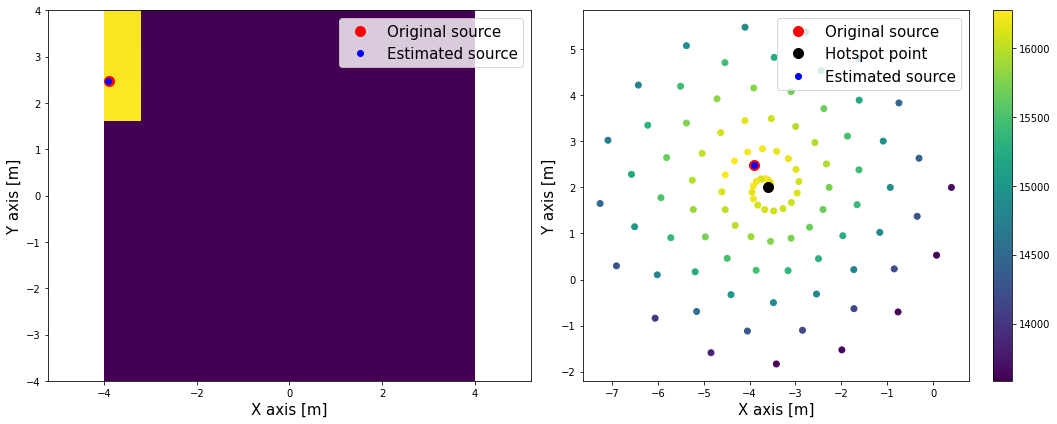

In [23]:
def visualize(data):
    measurement = data['measurement']
    estimate = data['sourceCF']

    X, Y = measurement['source'][0], measurement['source'][1]
    x_max, y_max = measurement['x_max'], measurement['y_max']
    HDs = measurement['m_dose']

    fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 6))
    
    im = ax1.imshow(measurement['maps'], extent=[-x_max,x_max,-y_max,y_max], aspect="auto")
    ax1.plot(X, Y, "o", color = 'r', ms=10, label = "Original source")
    ax1.plot(estimate[0], estimate[1], 'o', color = "b", ms = 6, label = "Estimated source")

    ax1.axis("equal")
    ax1.set_xlabel("X axis [m]", fontsize = 15)
    ax1.set_ylabel("Y axis [m]", fontsize = 15)
   
    ax1.legend(fontsize = 15)

    x_h, y_h = measurement['hotspot'][0], measurement['hotspot'][1]
    x_data = measurement['x_data']; y_data = measurement['y_data']

    ax2.plot(X, Y, 'o', color = 'r', ms=10, label = "Original source")
    ax2.plot(x_h, y_h, 'o', color = 'k', ms=10, label = "Hotspot point")
    im0 = ax2.scatter(x_data, y_data, c=HDs)
    ax2.plot(estimate[0], estimate[1], 'o', color = "b", ms = 6, label = "Estimated source")


    # ax2.plot(x_data, y_data, "o", color = "k", label = "Measurements")

    ax2.set_xlabel("X axis [m]", fontsize = 15)
    ax2.set_ylabel("Y axis [m]", fontsize = 15)
   
    ax2.legend(fontsize = 15)

    fig.colorbar(im0, ax=ax2)

    plt.tight_layout()
    # plt.savefig("graphics/imporved.jpg")
    plt.show()
    # return points[1]
    # print(measurement["intensities_array"], '\n', measurement["grid_x"], '\n', measurement["grid_y"])

data = combination(radiation, detector)
visualize(data)

# An error that can occur is if we input to large of a number of grids the difference between the neighbouring tiles might be overshadowed by
# the poisson distribution error of the detector. This will result in the detector stoping before reaching the hotspot tile.


##

# Tutorials

<class 'numpy.ndarray'> 
 (50,) 
 [0.78422978 0.39704754 0.15464683 0.72119325 0.8368309  0.9378552
 0.57671382 0.19502656 0.11779397 0.9506002  0.2836723  0.95656242
 0.90942546 0.32842519 0.95176557 0.11632148 0.87431415 0.98522547
 0.75033538 0.98515647 0.99018024 0.06097709 0.00373598 0.81250321
 0.58273672 0.15024598 0.15217356 0.5270595  0.4794052  0.09218994
 0.51195743 0.04283111 0.80629615 0.24219866 0.8482111  0.69558986
 0.36132686 0.50570144 0.29417242 0.66008457 0.53413535 0.19481606
 0.86190568 0.97802889 0.88218663 0.52735917 0.22140904 0.20272247
 0.0755575  0.95256799]


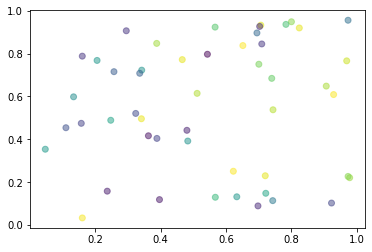

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Fixing random state for reproducibility
np.random.seed(19680801)


N = 50
x = np.random.rand(N)
y = np.random.rand(N)
colors = np.random.rand(N)
area = (30 * np.random.rand(N))**2  # 0 to 15 point radii

print(type(x), "\n", y.shape, "\n", colors)

plt.scatter(x, y, c=colors, alpha=0.5)
plt.show()